### Feedforward Neuronal Network auf dem Ames Housing Price Data Set von kaggle.com

Einmalige Installation notwendiger Pakete wird in VL 3 beschrieben. Verwendet werden hier die Bibliotheken 
pandas, numpy, matplotlib, seaborn, sklearn, imblearn, bokeh einmalig installieren, wenn ModuleNotFound error 
auftritt dann Zelle als Zelltyp Code umwandeln und ausführen

#### Versionsgeschichte

- 1.0 21.05.2023 Willi Hahn Initialversion
- 1.5 13.08.2024 Willi Hahn plot_gridsearch angefügt. update fixes für Bokeh.
- 1.6 23.07.2025 Willi Hahn Anpassung Pfade auf github, Logging mit Datendatei erweitert.

In [1]:
# notwendige Bibliotheken importieren und konfigurieren 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
_ = pd.set_option('display.max_columns', None) # damit mehr als 20 Spalten angezeigt werden.
pd.set_option('display.min_rows', 8) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
pd.set_option('display.max_rows', 500) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
import numpy as np
from collections import Counter
from timeit import default_timer as timer
import os
from math import ceil
from itertools import zip_longest
import seaborn as sns #importing Seaborn's for plots
from sklearn import metrics as met 
import matplotlib.pyplot as plt #Plot Bibliothek
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, LassoSelectTool, Plot, WheelZoomTool, BoxZoomTool, ResetTool

# workaround für manchmal verschwindende Anzeige von Zellen in Standard Jupyter (nicht in Jupyterlab), Stand 07/2025
from IPython.display import display, HTML

display(HTML("""
<style>
div.output_scroll {
    overflow-y: auto;
    max-height: 500px;
}
</style>
"""))


scriptname='Ames FNN.ipynb'
logtext=""
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(
    force=True,
    level=logging.INFO,
    format="%(asctime)s;%(levelname)s;%(message)s;",
    datefmt="%y-%m-%d %H:%M:%S",
    encoding='utf-8',
    filemode='a',
    filename="AllScripts.log" # Default ist append
)
logger = logging.getLogger()


In [2]:
# Daten einlesen
path = 'c:/myBox/Projekte/python/Ames_Cleaned_26_v1.csv'# für lokale Dateien
#path = 'https://raw.githubusercontent.com/WilliHahn/FHDW/main/Ames_Cleaned_26_v1.csv'
df = pd.read_csv(path, sep=',') 
datendateiname = os.path.basename(path)

# Originaldaten einlesen für Unersuchungen der Vorhersagen
path = 'c:/myBox/Projekte/python/AmesHousing.csv' # für lokale Dateien
#path = 'https://raw.githubusercontent.com/WilliHahn/FHDW/main/AmesHousing.csv'
df_org= pd.read_csv(path, sep=',') 


In [3]:
# Kontrolle der Datenvorbereitung bevor es an die Modellerstellung geht
df.info(verbose=True, show_counts=True)
df.isnull().sum().sum()
# fehlende Werte anzeigen
null_stats = pd.DataFrame(df.isnull().sum(), columns=['missing_value_count'])
null_stats.loc[:,'% of dataset'] = np.round(null_stats.loc[:,'missing_value_count'] / df.shape[0] * 100, 2)
null_stats.loc[null_stats.loc[:,'missing_value_count']>0,:].sort_values(by='missing_value_count', ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2690 entries, 0 to 2689
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SalePrice            2690 non-null   int64  
 1   Order                2690 non-null   int64  
 2   Bsmt Qual            2690 non-null   float64
 3   Exter Qual           2690 non-null   int64  
 4   Fireplace Qu         2690 non-null   float64
 5   Functional           2690 non-null   int64  
 6   Garage Area          2690 non-null   int64  
 7   Garage Qual          2690 non-null   float64
 8   Gr Liv Area          2690 non-null   int64  
 9   HouseAge             2690 non-null   int64  
 10  TotalPorchSF         2690 non-null   int64  
 11  Kitchen Qual         2690 non-null   int64  
 12  Land Contour         2690 non-null   int64  
 13  Lot Area             2690 non-null   int64  
 14  Lot Frontage         2690 non-null   float64
 15  Lot Shape            2690 non-null   i

np.int64(0)

,missing_value_count,% of dataset


In [4]:
# Trainings- und Testdaten aufteilen
TESTANTEIL = 0.25 # Split der Test- und Trainingsdaten
# Trennung von unabhängigen Variablen und abhängiger Zielvariable
#y = pd.DataFrame (df['SalePrice']) #13.08.2024 um zu verhindern, dass y* zu Series werden.
y = df['SalePrice']
x = df.drop(['SalePrice'], axis = 1)
dfx_test = pd.DataFrame(data=x, columns=x.columns) # vor Skalierung mit Oringinalwerten für tool tips in bokeh Graphiken
x.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
#x.head().T
#y.head().T
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TESTANTEIL, random_state=4711)
# und prüfen durch ansehen
print ('x_train', x_train.shape, type(x_train))
print ('y_train', y_train.shape, type(y_train))
print ('x_test',x_test.shape, type(x_test))
print ('y_test', y_test.shape, type(y_test))



x_train (2017, 26) <class 'pandas.core.frame.DataFrame'>
y_train (2017,) <class 'pandas.core.series.Series'>
x_test (673, 26) <class 'pandas.core.frame.DataFrame'>
y_test (673,) <class 'pandas.core.series.Series'>


In [5]:
# Skalierung der unabhängigen Variablen
SCALER = StandardScaler()
#SCALER = MinMaxScaler()
scalerklassenname = type(SCALER).__name__
x_train = SCALER.fit_transform(x_train)
x_test = SCALER.transform(x_test)
print ('x_train', x_train.shape, type(x_train))
print ('x_test', y_train.shape, type(x_test))


x_train (2017, 26) <class 'numpy.ndarray'>
x_test (2017,) <class 'numpy.ndarray'>


GridSearchCV(cv=3,
             estimator=MLPRegressor(max_iter=4000, random_state=42,
                                    solver='lbfgs'),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'relu', 'tanh'],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (10,), (25,), (50,)]},
             return_train_score=True, scoring='neg_mean_absolute_error')


Laufzeit GridSearchCV =  56.0  sec

Parameter space: {'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,), (10,), (25,), (50,)], 'activation': ['identity', 'relu', 'tanh']}
Best score =  -16082.669240954345
Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (3,)} 



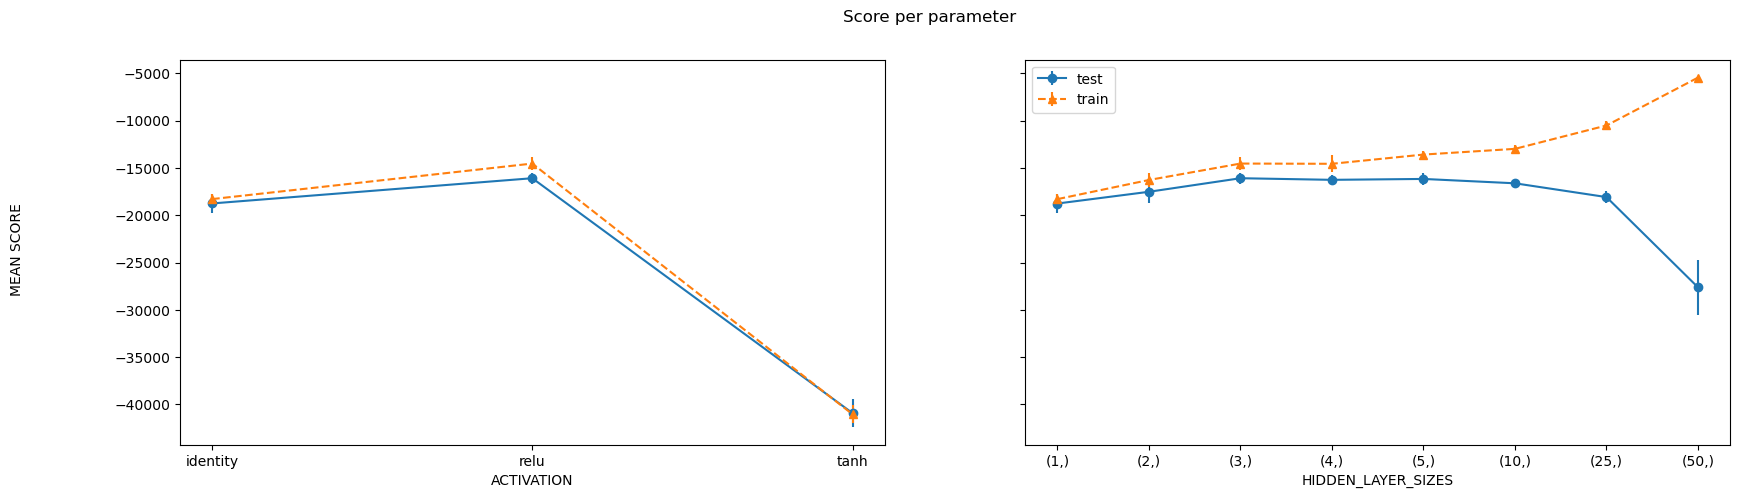

In [6]:
# Zuerst einaml GridSearchCV zur Bestimmung optimaler Hxperparameter eines FNN
# weil die Bandbreite möglicher FNN Konfigurationen groß ist

# siehe https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# siehe https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

def plot_gridsearch_results_V2 (grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    What:
        plot each score for each hyper parameter and its gridsearched variations. 
    Bugs:
        1) Fehler bei nur einem Hyperparameter (und nur einer Option)
            ValueError: need at least one array to stack, 40: m = np.stack(masks[:i] + masks[i+1:])
        2) FNN, "hidden_layer_sizes": [2, (2,2)] Error wegen tuple in array. Es geht [(2, ), (2,2)]
    """

    def convertTuples2arraystr (allValues):
        arr=[]
        #Umbau Tupel als array of string, damit im plot x bestimmt werden kann
        s1 = str(allValues).replace(", ",",").replace(" ",";").replace("),(",");(").replace("[","").replace("]","") # remove white space
        l1 = s1.split(";")
        arr = np.array(l1, dtype="str") 
        return (arr)
    
    def isTupleInside (allValues):
        """
        Params:
         allValues: list of gridsearch matrix, like ['identity' 'relu'], [(1, 1) (1, 1)] 
        """
        b=0
        for j in range(0,len(allValues)): 
            if type(allValues[j])==tuple: 
                b=1
            else: 
                b=0
        return(b)

    
    ## Results from grid search
    results = grid.cv_results_
    #print ("\ncv_results_=",results,)
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    stds_train = results['std_train_score']
    means_train = results['mean_train_score']

    params=grid.param_grid
    #print ("len(params)=",len(params), "params=",params)

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for k, v in grid.best_params_.items():
        kall=[]
        v=str(v).replace(" ","") # V1.1 für Tupel
        kall = results['param_'+k].data
        if isTupleInside(kall) == 1 : kall = convertTuples2arraystr (kall)
        masks.append(list(kall==v)) 
    #assert masks ==[[np.True_, np.False_], [np.True_, np.True_]], "Testfall 1: masks soll sein TFTT entspr. untersuchte param kombi"
    
    
    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        if isTupleInside(params[p]) == 1 : 
            x = np.array(convertTuples2arraystr(params[p]))
        else :
            x = np.array(params[p])
        #x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='-', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='--', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()


RANDOM_STATE = 42
MAX_ITER = 4000
SOLVER="lbfgs"
N_JOBS=-1
CV=3 # Anzahl cross folds
# Testfälle hier durch folgenden Parameterbblöcke nach unten verschieben. 
parameter_space = \
    { # FINAL 
        "hidden_layer_sizes": [  (1, ), (1, 1),  (2, ), (2, 1), (2,2), (2, 3), (3, 4), (4, 3), (3, 2), (5, 4)],  # zweischichtige FNN. list(range(1,2))
        "activation": ["identity","relu", "tanh"] , # "identity", ,"relu" "tanh"
    }
parameter_space = \
    { #  
        "hidden_layer_sizes": [  (10, ), (10, 10),  (20, ), (20, 10),  (50, ),  (50, 25)],  # einschichtige FNN. list(range(1,2))
        "activation": ["identity","relu", "tanh"] , # "identity", ,"relu" "tanh"
    }
parameter_space = \
    { #  
        "hidden_layer_sizes": [  (1, ), (2, ), (3, ), (4, ), (5, ), (10, ), (25,), (50,)],  # einschichtige FNN. list(range(1,2))
        "activation": ["identity","relu", "tanh"] , # "identity", ,"relu", "tanh"
    }
t0 = timer()
grid = GridSearchCV(MLPRegressor(random_state=RANDOM_STATE, max_iter=MAX_ITER, solver=SOLVER),
                parameter_space, 
                cv=CV, scoring="neg_mean_absolute_error", n_jobs=N_JOBS, return_train_score=True)
grid.fit(x_train, y_train)
#displax(grid.cv_results_)
t1 = timer()
print ('\nLaufzeit GridSearchCV = ', round(t1 - t0, 0), ' sec')

print("\nParameter space:", parameter_space)
print('Best score = ' , grid.best_score_)
print("Best parameters:", grid.best_params_,"\n")

_ = plot_gridsearch_results_V2 (grid)


In [7]:
# development checks of gridsearch results
grid.cv_results_['params'][np.argmax(grid.cv_results_['mean_test_score'])]

# hard coded für test hyper parameter!
df=pd.DataFrame(grid.cv_results_)[['param_activation','param_hidden_layer_sizes','mean_test_score']]
df




{'activation': 'relu', 'hidden_layer_sizes': (3,)}

,param_activation,param_hidden_layer_sizes,mean_test_score
0,identity,"(1,)",-18751.696022
1,identity,"(2,)",-18751.664709
2,identity,"(3,)",-18751.679584
3,identity,"(4,)",-18751.603143
4,identity,"(5,)",-18751.649799
5,identity,"(10,)",-18751.667224
6,identity,"(25,)",-18751.721775
7,identity,"(50,)",-18751.674302
8,relu,"(1,)",-18758.898601
9,relu,"(2,)",-17517.093437


In [8]:
# FNN Modell erstellen mit besten Hyperparametern aus dem gridsearch

hyper_params = {'activation': 'relu', 'hidden_layer_sizes': [3], 'max_iter': 2000, 'solver': 'lbfgs', 'random_state': 42}
t0 = timer()
model = MLPRegressor(**hyper_params)
model.fit(x_train, y_train);
t1 = timer()
print ('Laufzeit Modellerstellung = ', round(t1 - t0, 0), ' sec')
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("MAE =", mae)
print("MSE", mse)
print("RMSE",rmse)
r2 = r2_score(y_test,y_pred)
print('Model Score R2: ', r2)
adjusted_r2 = 1 - (1-r2)*(len(y_pred)-1)/(len(y_pred)-x_test.shape[1]-1)
print('Model Score R2 Adjusted: ', adjusted_r2)

print(f"Number of inputs:  {model.n_features_in_}")
print(f"Number of outputs: {model.n_outputs_}")
print(f"Number of layers:  {model.n_layers_}")
print(f"Layer sizes: {[l.shape for l in model.coefs_]}")

logging.info(scriptname + ';' + datendateiname + ';' + scalerklassenname + "; Data Frame: "+str(df.shape[0])+ ";"+ str(df.shape[1])+ 
             "; Testanteil: "+ f'{TESTANTEIL:9.2f}'+ ";")
logging.info(scriptname + ';' + str(hyper_params))
logging.info(scriptname + '; MAE=' + f'{mae:0.0f}' + "; RMSE=" + f'{rmse:0.0f}'+ "; R2=" + f'{r2:0.2f}'+ "; R2 adj.="+ 
             f'{adjusted_r2:0.2f}'+ ";")



MLPRegressor(hidden_layer_sizes=[3], max_iter=2000, random_state=42,
             solver='lbfgs')

Laufzeit Modellerstellung =  1.0  sec
MAE = 16233.671809095491
MSE 564492541.1514426
RMSE 23759.051772986284
Model Score R2:  0.8949478614602917
Model Score R2 Adjusted:  0.8907197568131827
Number of inputs:  26
Number of outputs: 1
Number of layers:  3
Layer sizes: [(26, 3), (3, 1)]


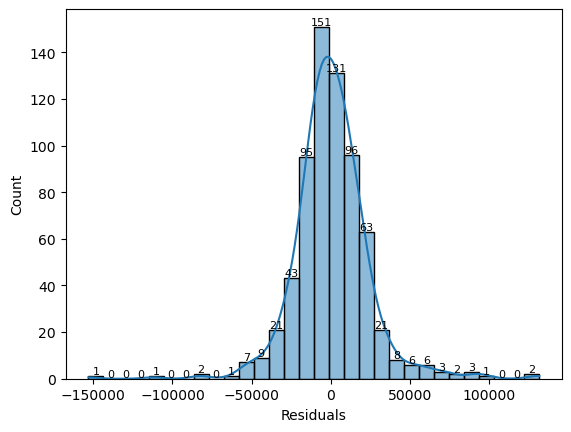

In [9]:
# Sind die die Residuen zwischen wirklichen und vorhergesagten Verkaufspreisen normalverteilt?
residuals = y_test - y_pred
y = sns.histplot(residuals, bins=30, kde=True)
_ = y.bar_label(y.containers[0], fontsize = 8) # Beschriftung der bins. deswegen seaborn.
_ = plt.xlabel('Residuals')
#plt.scatter(x=residuals, x=data['x'])
#plt.xlabel('Residuals')
#plt.ylabel('Independent variable x')
plt.show()

In [10]:
# Zeichne wahre Hauspreise gegen Vorhersagen, mit tool tips

output_notebook(resources=None, verbose=True, hide_banner=True)

df_comparison = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
df_tip=pd.concat([df_comparison,dfx_test], axis=1, join='inner') 
df_tip['Order'] = dfx_test['Order'].astype('int64')
df_tip=df_tip.join(df_org[["Neighborhood"]], on="Order", how="inner")
# df_tip.loc[df_test["Order"] == 433]

source = ColumnDataSource(df_tip)

hover = HoverTool(
        tooltips=[
            ("OrderNo", "@Order")
             , ("Sale Price Actual", "@Actual{0}")
             , ("Sale Price Predicted", "@Predicted{0}")
             , ("House Age", "@HouseAge{0}")
             , ("Remodel Age", "@RemodelAge{0}")
             , ("Lot Area", "@{Lot Area}{0}")
             , ("Total Living Area", "@TotalLivingSF{0}")
             , ("Bathrooms", "@TotalBathroom{0.0}")
             , ("Neighborhood", "@Neighborhood")
        ]
    )

p = figure(width=800, height=400, tools=[hover],
           title="Actual vs predicted Sale Price (see tool tip)", x_range=(0, 700000), 
               y_range=(0, 700000),
           toolbar_location="right", toolbar_sticky=False)
p.add_tools(WheelZoomTool(), BoxZoomTool(), ResetTool())
p.xaxis.axis_label = 'Actual Sale Price'
p.xaxis.axis_label = 'Predicted Sale Price'
p.left[0].formatter.use_scientific = False
p.below[0].formatter.use_scientific = False
_ = p.scatter('Actual', 'Predicted', size=10, source=source)
_ = show(p)

In [11]:
# Offene vergleiche Gewichte einen EIn Neuron Netzes mit den Koeffizienten einer linearen Regression
